In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing as pp
import category_encoders as ce

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# **ПРОЕКТ 3: Соревнование на KAGGEL "[SF-DST] Booking reviews"**
* _Описание:_ Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить. Вам поставлена задача создать такую модель.
* _Условия соревнования:_ 
  1. Данное соревнование является бессрочным и доступно для всех потоков.

  2. Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

  3. Тестовая выборка представлена в LeaderBoard целиком.

  4. Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

# Читаем данные
---

In [5]:
df_test = pd.read_csv('PROJECT-3. EDA  Feature Engineering\data\hotels_test.csv')
df_train = pd.read_csv('PROJECT-3. EDA  Feature Engineering\data\hotels_train.csv')
sub = pd.read_csv('PROJECT-3. EDA  Feature Engineering\data\submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'PROJECT-3. EDA  Feature Engineering\\data\\hotels_test.csv'

In [3]:
RANDOM_SEED = 42

In [4]:
!pip freeze > requirements.txt

# Объединяем обучающую выборку и тестовую выборку
---

In [5]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

C:\Users\79779\AppData\Local\Temp\ipykernel_12636\3116296663.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

In [8]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


# В качестве введения.
При работе над этим проектом я выбрал экспериментальный подход проб и ошибок, как и многие успешные работы в этом соревновании. 
1. После изучения датасета первым делом пробовал моделировать самые очвидные признаки (например город, страна и т.п.), параллельно проверяя метрику.
2. По мере погружения в данные появлялись новые идеи для фич инженеринга.
3. В конечном счете, большую часть реализованных идей в процессе экпериментов пришлось отвергнуть как негативно влияющие на метрику.

# 1. Признаки полученные из hotel_address
---

### a. Первое на что можно обратить внимание это строковый признак hotel_address из которого можно получить как минимум, два признака city и country

In [9]:
data['country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split(' ')[-1] == 'Kingdom' else str(x.split(' ')[-1:]).strip("['']"))
def get_city(x):
    city = x.split(' ')[-2]
    if city == 'United':
        return 'London'
    else:
        return city

data['city'] = data['hotel_address'].apply(get_city)

In [10]:
data[['city', 'country']].value_counts()

city       country       
London     United Kingdom    262301
Barcelona  Spain              60149
Paris      France             59928
Amsterdam  Netherlands        57214
Vienna     Austria            38939
Milan      Italy              37207
dtype: int64

### b. Признак post_code
*в дальнейшем поможет заминить пропуски в столбцах 'lat' и 'lng'*

In [11]:
data['post_code'] = data['hotel_address'].apply(lambda x: x.split()[-4] if x == 'United' else x.split()[-3])

# 2. Признаки геолокации
---

* Замена пропусков на медиану или среднее или нули давали худший результат, чем замена на координаы центра города. Но и от координат центра города решил отказаться в пользу координат, полученных при помощи индекса.
* Можно было потратить время на поиск через карты и вручную дописать координаты отелей, но так как курс все таки про работу с python, то было принято решение использовать библиотеку geopy.

In [12]:
# заменил NaN на 0 - удобнее работать
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

In [13]:
# создаем словарь, где
## ключ - индекс, значение - координаты по индесу
zip_list = data['post_code'].value_counts().index.to_list()
len(zip_list)

566

In [14]:
# разделил на 2 части,
## так как geopy отказывался обрабатывать один большой список
x = zip_list[:283]
y = zip_list[283:]

In [15]:
zip_dict = {}
for code in x:
    geo = Nominatim(user_agent="Good_sfprj_1")
    loc = geo.geocode(code)
    if loc:
        zip_dict[code] = (loc.latitude, loc.longitude)

In [16]:
for code in y:
    geo = Nominatim(user_agent="Good_sfprj_2")
    loc = geo.geocode(code)
    if loc:
        zip_dict[code] = (loc.latitude, loc.longitude)

In [17]:
def get_lat(row):
    if row['lat'] != 0:
        return row['lat']
    else:
        return zip_dict[row['post_code']][0]


data['lat'] = data.apply(get_lat, axis=1)

# 3. Признаки, полученные из национальности ревьюера
---

## Признак is_residence
Отражает совпадение страны отеля и пользователя писавшего отзыв (1 - страна отеля и пользователя совпадает, 0 - не совпадает)

In [18]:
def get_residence(row):
    if row['country'] == row['reviewer_nationality'].strip():
        return 1
    else:
        return 0

data['is_residence'] = data.apply(get_residence, axis=1)

# 4. Изучение тэгов

## a. Выделим топ 10 частоиспользуемых тэгов

In [19]:
tags = data['tags'].value_counts().index.to_list()

In [20]:
top_tags = {}
for unit in tags:
    unit = unit.strip("[]")
    unit = unit.split(",")
    for item in unit:
        item = item.strip("'  '")
        if item not in top_tags:
            top_tags[item] = 1
        else:
            top_tags[item] += 1

In [21]:
top_10 = list(top_tags.keys())[:13]
top_10

['Leisure trip',
 'Couple',
 'Double Room',
 'Stayed 1 night',
 'Submitted from a mobile device',
 'Standard Double Room',
 'Superior Double Room',
 'Deluxe Double Room',
 'Stayed 2 nights',
 'Stayed 3 nights',
 'Double or Twin Room',
 'Classic Double Room',
 'Business trip']

In [22]:
for tag in top_10:
    if "night" in tag:
        top_10.remove(tag)
        
top_10.remove('Stayed 3 nights') #тэг не сортировался в цикле, поэтому удаляю напрямую
top_10

['Leisure trip',
 'Couple',
 'Double Room',
 'Submitted from a mobile device',
 'Standard Double Room',
 'Superior Double Room',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Classic Double Room',
 'Business trip']

### *Не будем учитывать тэги с количеством ночей, далее выделим этот тэг в отдельный признак

In [23]:
# Для каждого топ-тэга создаем отдельный бинарный признак
for tag in top_10:
    data[tag] = data['tags'].apply(
    lambda x: 1 if tag in x else 0)

## b. Создаем признак nights

In [24]:
def get_nights(row):
    row = row.strip("[]")
    row = row.split(",")
    for item in row:
        item = item.strip("'  '")
        if "Stayed" in item:
            return int(item.split(" ")[1])


data['nights'] = data['tags'].apply(get_nights)

In [25]:
# заменяем пропуски медианным знаением 
data['nights'] = data['nights'].fillna(data['nights'].median())

# 5. Выделяем признаки день года и кол-во дней после отзыва
---

In [26]:
data['date'] = pd.to_datetime(data['review_date'], dayfirst=False)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day_of_year
data.drop('date', axis=1, inplace=True)

data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(" ")[0]))

# 6. Выделяем два булевых признаков:
1) is_positive_review (0 - отзыв непозитивный, 1 - отзыв позитивный)
2) is_negative_review (0 - отзыв ненегативный, 1 - отзыв негативный)
---

In [27]:
negative_list = data['negative_review'].value_counts().index.to_list()[:8]
negative_list

def get_negative(x):
    if x in negative_list:
        return 0
    else:
        return 1

data['is_negative_review'] = data['negative_review'].apply(get_negative)

In [28]:
positive_list = negative_list[1:]
positive_list.append("No Positive")

def get_positive(x):
    if x in positive_list:
        return 0
    else:
        return 1
data['is_positive_review'] = data['positive_review'].apply(get_positive)

 # 7. Добавляем признаки тональности текста
 ---

In [29]:
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def get_nltk(x):
    result = sent_analyzer.polarity_scores(x)
    return result

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\79779\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
# для позитивных отзывов
data['nltk_p'] = data['positive_review'].apply(get_nltk)
data['neg_p'] = data['nltk_p'].apply(lambda x: x['neg'])
data['neu_p'] = data['nltk_p'].apply(lambda x: x['neu'])
data['pos_p'] = data['nltk_p'].apply(lambda x: x['pos'])
data['compound_p'] = data['nltk_p'].apply(lambda x: x['compound'])

In [31]:
# дле негативных отзывов
data['nltk_n'] = data['negative_review'].apply(get_nltk)
data['neg_n'] = data['nltk_n'].apply(lambda x: x['neg'])
data['neu_n'] = data['nltk_n'].apply(lambda x: x['neu'])
data['pos_n'] = data['nltk_n'].apply(lambda x: x['pos'])
data['compound_n'] = data['nltk_n'].apply(lambda x: x['compound'])

In [32]:
# удаляем лишние столбцы 
data.drop(['nltk_n', 'nltk_p'], axis=1, inplace=True)

# 8. Кодирование признаков
---

In [33]:
bin_code = ce.BinaryEncoder(cols=['reviewer_nationality'])
coding = bin_code.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, coding], axis=1)

In [34]:
bin_code = ce.BinaryEncoder(cols=['city'])
coding = bin_code.fit_transform(data['city'])
data = pd.concat([data, coding], axis=1)

In [35]:
bin_code = ce.BinaryEncoder(cols=['country'])
coding = bin_code.fit_transform(data['country'])
data = pd.concat([data, coding], axis=1)

* при бинарном кодировании метрика получается лучше.

# 7. Изучение мультиколлениарности
---

C:\Users\79779\AppData\Local\Temp\ipykernel_12636\2962108069.py:34: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ], axis=1).corr().round(1), annot=True)


Text(0.5, 1.0, 'Тепловая карта корреляций категориальных признаков')

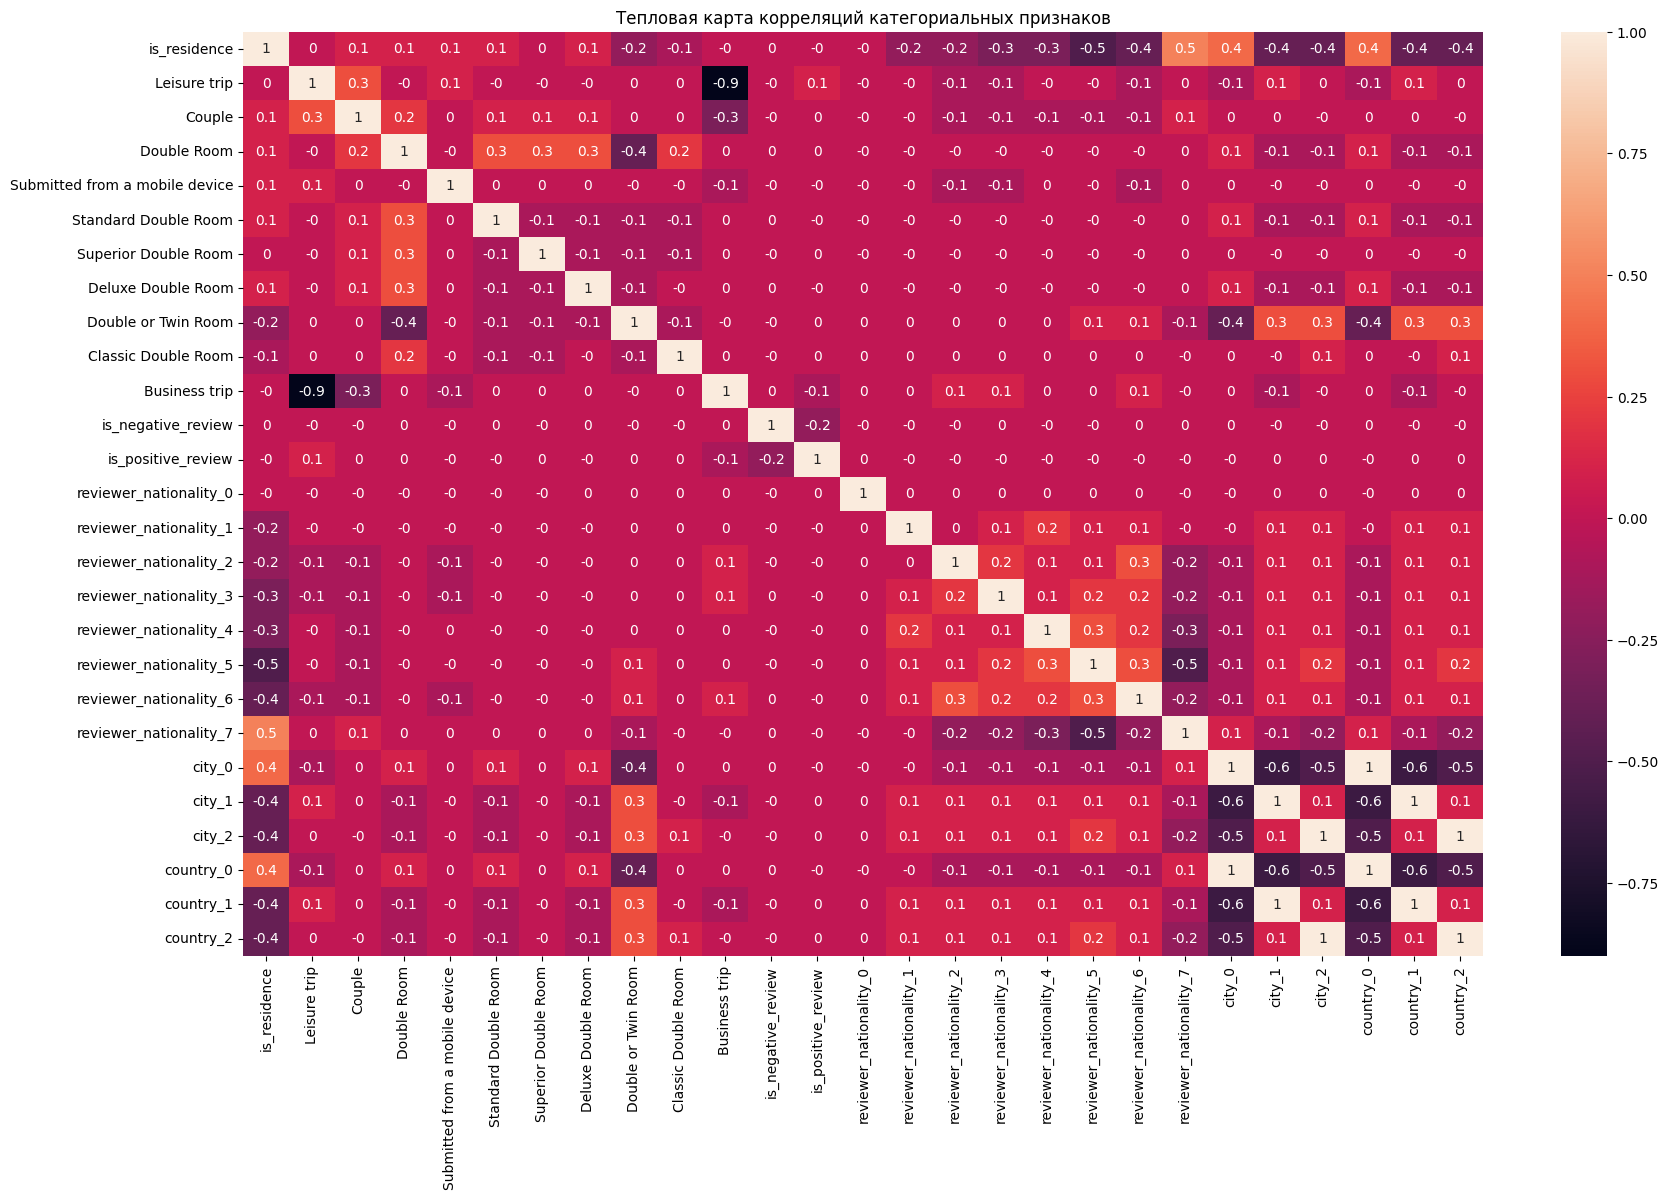

In [36]:
plt.rcParams['figure.figsize'] = (20, 12)
# тепловая карта для отображения корреляции категориальных признаков
fig = sns.heatmap(data.drop([
    'hotel_address', 
    'additional_number_of_scoring', 
    'review_date',
    'average_score', 
    'hotel_name', 
    'reviewer_nationality',
    'negative_review', 
    'review_total_negative_word_counts',
    'total_number_of_reviews', 
    'positive_review',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 
    'tags',
    'days_since_review', 
    'lat', 
    'lng', 
    'sample', 
    'reviewer_score',
    'nights',
    'year', 
    'month', 
    'day',
    'neg_p', 
    'neu_p', 
    'pos_p', 
    'compound_p', 
    'neg_n', 
    'neu_n', 
    'pos_n',
    'compound_n'
], axis=1).corr().round(1), annot=True)
fig.set_title('Тепловая карта корреляций категориальных признаков')

C:\Users\79779\AppData\Local\Temp\ipykernel_12636\1280358173.py:40: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ], axis=1).corr().round(1), annot=True)


Text(0.5, 1.0, 'Тепловая карта корреляций категориальных признаков')

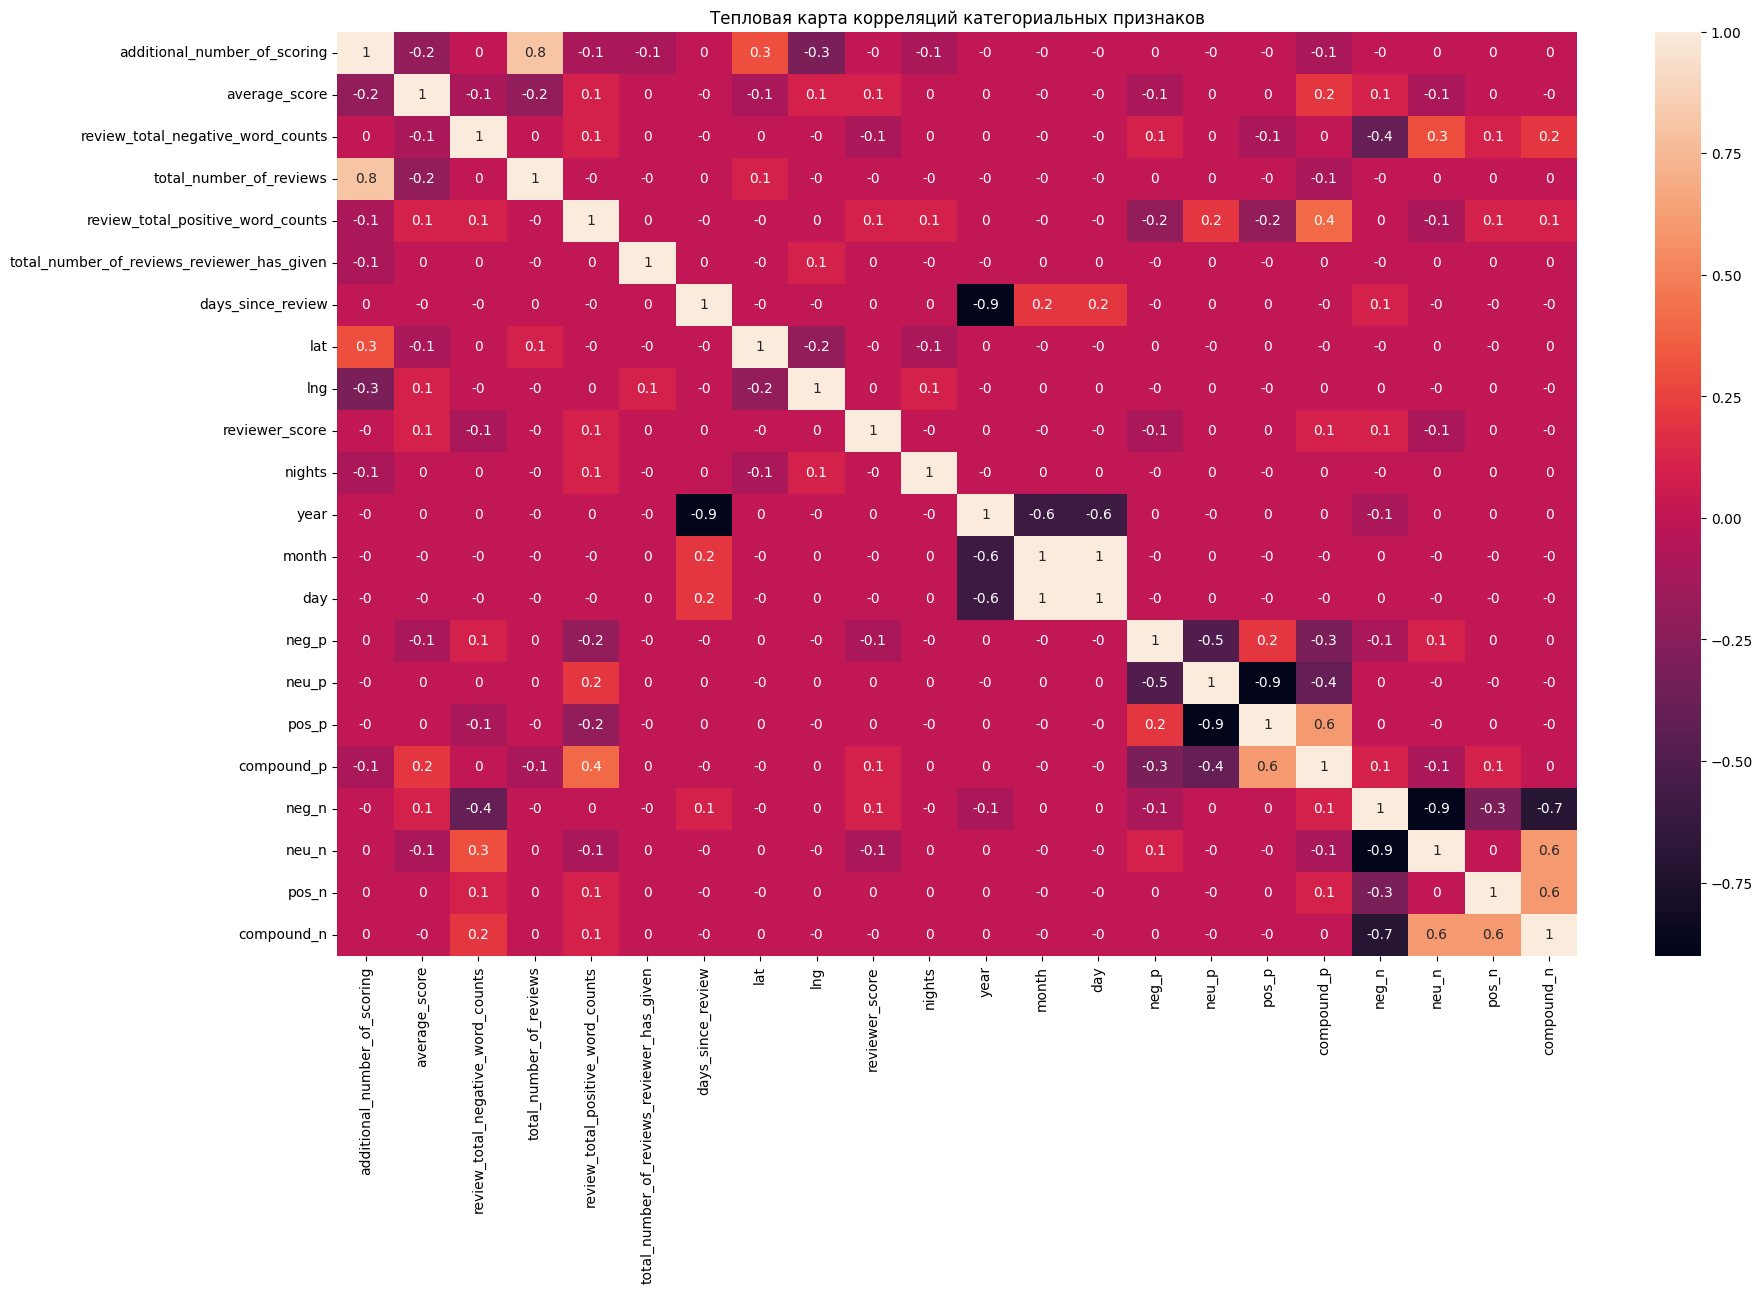

In [37]:
plt.rcParams['figure.figsize'] = (20, 12)
# тепловая карта для отображения корреляции непрерывных признаков
fig = sns.heatmap(data.drop([
    'hotel_address',
    'review_date',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    'positive_review',
    'tags',
    'sample',
    'post_code',
    'is_residence',
    'Leisure trip',
    'Couple',
    'Double Room',
    'Submitted from a mobile device',
    'Standard Double Room',
    'Superior Double Room',
    'Deluxe Double Room',
    'Double or Twin Room',
    'Classic Double Room',
    'Business trip',
    'is_negative_review',
    'is_positive_review',
    'reviewer_nationality_0',
    'reviewer_nationality_1',
    'reviewer_nationality_2',
    'reviewer_nationality_3',
    'reviewer_nationality_4',
    'reviewer_nationality_5',
    'reviewer_nationality_6',
    'reviewer_nationality_7',
    'city_0', 
    'city_1',
    'city_2', 
    'country_0', 
    'country_1', 
    'country_2'
], axis=1).corr().round(1), annot=True)
fig.set_title('Тепловая карта корреляций категориальных признаков')

## a. удалим признаки которые имеют корреляцию 0.9 и выше

In [38]:
data.drop(['month', 
           'neu_n', 
           'neu_p',
           'days_since_review'
], axis=1, inplace=True)

## b. Создаем признак part_real_reviews
* признаки additional_number_of_scoring и total_number_of_reviews имеют корреляцию 0.8, но признаки оказывают существенное влияние на результат и полностью отказываться от них не хочется

In [39]:
def get_ratio(row):
    x = row['additional_number_of_scoring']
    y = row['total_number_of_reviews']
    result = (y - x ) / y
    return result

data['part_real_reviews'] = data.apply(get_ratio, axis=1)

data.drop(['additional_number_of_scoring', 'total_number_of_reviews'], axis=1, inplace=True)

## c. Удаляем один все признаки кодирующие страну.
* так как содержит одинаковую информацию с признаками city

In [40]:
data.drop(['country_0', 'country_1', 'country_2',], axis=1, inplace=True)

## d. Удаление оставшихся нечисловых признаков

In [41]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

## e. Нормализация признаков 'Leisure trip' и 'Business trip'
* хочу отметить, что нормализачия других числовых признаков приводит к значительному улучшению метрики (больше чем на один порядок), но значительно просаживает рейтинг в соревновании на kaggle. В данном случае нормализация незначительно влияет на финальный результат, использовал для тренировки.

In [42]:
r_scaler = pp.MinMaxScaler()
df_r = r_scaler.fit_transform(data[['Leisure trip', 'Business trip']])
df_r = pd.DataFrame(df_r, columns=['r_Leisure trip', 'r_Business trip'])

data = pd.concat([data, df_r], axis=1)

data.drop(['Leisure trip', 'Business trip'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   lng                                         515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   is_residence                                515738 non-null  int64  
 

# 8. Работа с моделью
---

In [43]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [44]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [45]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 41), (386803, 41), (386803, 40), (309442, 40), (77361, 40))

In [48]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [51]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [52]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


In [53]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8690883179724492


<AxesSubplot: >

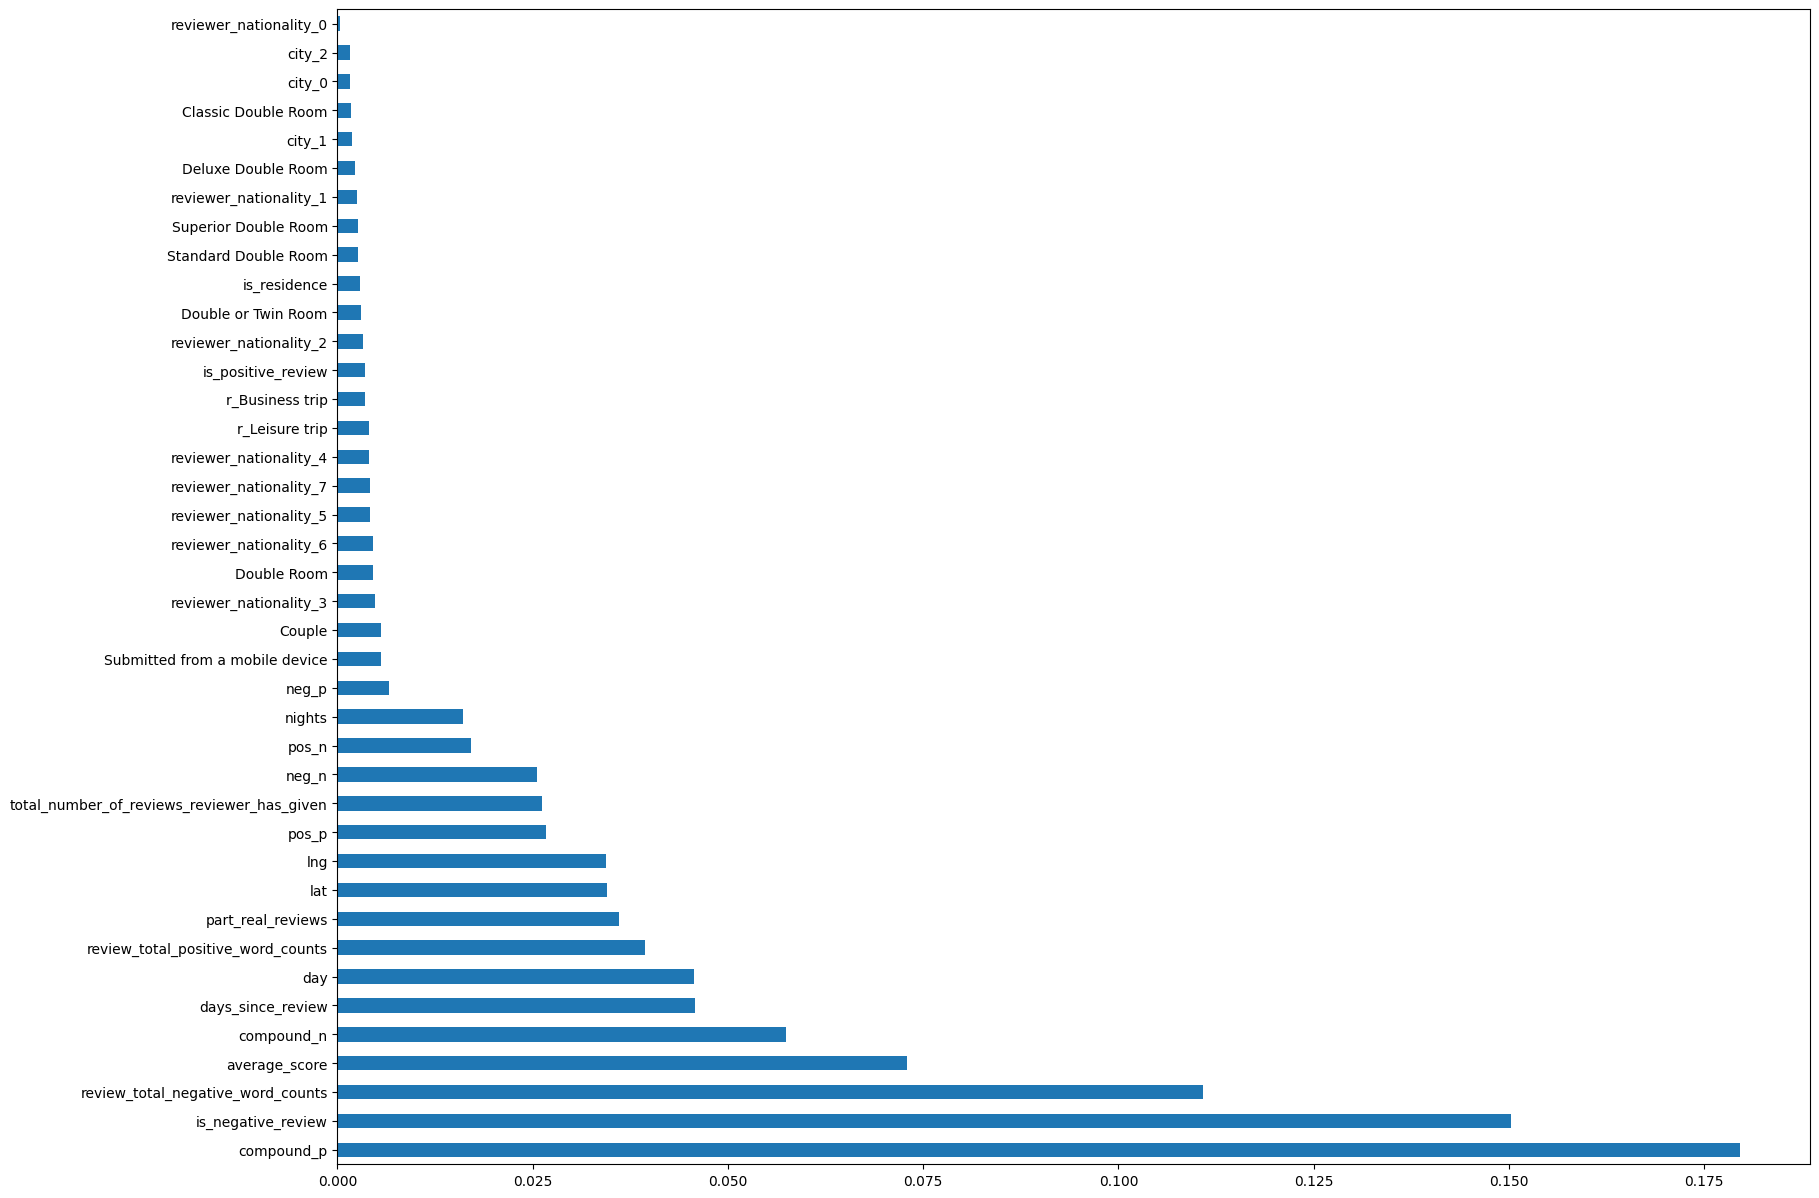

In [54]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (19,15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(46).plot(kind='barh')

In [55]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,is_residence,Couple,...,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,city_0,city_1,city_2,part_real_reviews,r_Leisure trip,r_Business trip
24846,9.0,17,0,1,108,45.460860,9.189022,0.0,0,1,...,0,0,0,1,0,0,1,0.882395,1.0,0.0
116281,8.6,7,4,2,178,51.517608,-0.127625,0.0,1,0,...,0,0,0,1,1,0,0,0.761121,0.0,1.0
18638,9.3,12,0,18,445,45.465137,9.189525,0.0,0,0,...,0,0,0,1,0,0,1,0.873695,1.0,0.0
77863,8.8,0,27,3,689,52.384606,4.894187,0.0,0,0,...,0,1,0,0,0,1,0,0.865755,1.0,0.0
64857,8.3,14,7,7,23,45.525722,9.215003,0.0,0,0,...,1,0,0,1,0,0,1,0.948072,1.0,0.0
65195,8.9,5,7,2,171,48.202274,16.376261,0.0,0,0,...,0,0,0,1,1,1,0,0.836170,1.0,0.0
508,8.2,9,30,9,256,51.480163,-0.009720,0.0,1,1,...,0,0,0,1,1,0,0,0.787573,0.0,1.0
29321,8.4,16,24,18,579,51.510843,-0.131429,0.0,1,1,...,0,0,0,1,1,0,0,0.704519,1.0,0.0
32173,7.5,0,4,3,153,51.499968,-0.159993,0.0,0,0,...,0,1,0,0,1,0,0,0.723598,1.0,0.0
8375,9.2,0,32,2,656,51.489123,-0.120564,0.0,0,1,...,0,1,0,0,1,0,0,0.873315,1.0,0.0


In [56]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [57]:
sub

,reviewer_score,id
0,8.578,488440
1,7.560,274649
2,8.326,374688
3,9.686,404352
4,9.551,451596
...,...,...
128930,8.702,495812
128931,9.490,315577
128932,8.067,511968
128933,9.606,303386


In [58]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.7s finished


In [59]:
predict_submission

array([8.622, 7.303, 8.223, ..., 8.316, 9.494, 7.492])

In [60]:
list(sub)

['reviewer_score', 'id']

In [61]:
sub['reviewer_score'] = predict_submission
sub.to_csv('data/submission.csv', index=False)
sub.head()

,reviewer_score,id
0,8.622,488440
1,7.303,274649
2,8.223,374688
3,9.629,404352
4,9.635,451596


# 9. Результаты и выводы
---

1) Самого лучшего результата MAPE удалось получить, при нормализации всех признаков, но как я писал выше, иоговый рейтинг от этого страдает очень сильно.
2) Удалось улучшить метрику до 8.7. Можно было и дальше "играться" с данными и метрикой, но нужно продолжать курс, поэтому остановился на среднем результате.

3) Кроме того в ходе реализации проекта:<br>
   * a. получил интересный опыт работы с даными, применив на практике материал курса.
   * b. Потренировался в написании кода на python, познакомился с новыми билиотеками.
   * c. Познакомился с процессом обуения модели и ее предсказанием. Разобрался с kaggel и ориентацией по этому ресурсу.
